In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sys,os,pickle,itertools
%matplotlib inline
import matplotlib as matplotlib
#matplotlib.use('TkAgg') #incompatible with qt, which is currently used
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn import svm, metrics
from sklearn.model_selection import StratifiedKFold, GridSearchCV,train_test_split
import fnmatch, shutil, itertools, re,time
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score, roc_curve,balanced_accuracy_score
from collections import Counter
from sklearn.metrics import confusion_matrix
import time
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import itertools, collections
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

#import random

#random.seed(10)
#np.random.seed(10)

In [31]:
'''UTILITY FUNCTIONS'''

def make_dir(paths):
    '''creates directory path (or multiple directories if needed) if they 
    #don't exist and returns the path created
    If dir. exists, then nth is done, just path is returned!
    '''

    if isinstance(paths,list):
            
        if len(paths)>2:
            path = paths[0]
            for i in range(1,len(paths)):
                path = os.path.join(path,paths[i])
            if os.path.exists(path) == False :
                os.makedirs(path)
                
        elif len(paths)==2:
            path = os.path.join(paths[0],paths[1])
            if os.path.exists(path) == False :
                os.makedirs(path)
            
        elif len(paths)==1:
            path = paths[0]
            if os.path.exists(path) == False :
                os.mkdir(path= path)
                
        else:
            raise ValueError('Length of list of paths has to be larger than 0')


    elif isinstance(paths,str):
        path = paths
        if os.path.exists(path) == False :
            os.mkdir(path= path)
    
    else:
        raise TypeError('Argument @paths must be list of strings or a string, indicating the dir.path')
    #all paths don't have '/' in the end!

    return path




def filter_out_rare_AAs(trigram_data):
    #filters out 3grams with rare amino acids from the 'trigram_data' dataframe
    
    #lambda for filtering
    amb_AAs = ['U','O','B','Z','J','X']
    contains_amb_AAs = lambda trigram: (any([amb_AA in trigram for amb_AA in amb_AAs]))
    
    #get list with indexes of n-grams that don't contain amb. AAs
    trigrams=trigram_data.iloc[:,0]
    indexes_amb_trigrams = [index for index,ngram in enumerate(trigrams)
                    if (contains_amb_AAs(ngram)) ] 
   
    #keep only the trigrams that don't contain ambiguous AAs
    trigram_data = trigram_data[~(trigram_data.index.isin(indexes_amb_trigrams))]
    trigram_data.reset_index(inplace=True,drop=True)
    
    return trigram_data



In [32]:
'''UTILITY CLASS FOR HIERARCHICAL CLUSTERING'''

class Hierarchical_clustering():
    def __init__(self,trigram_data,prot_data,hc,num_clusters,d_path):
        #np.random.seed(10)
        
        if hc==True :
            #mkdir results_Hierarchical_clustering_3grams
            curr_path = 'clusters='+str(num_clusters)
            d_path = make_dir(paths=[d_path,curr_path])            
            
            print('\nStarted Hierarchical clustering on tri-grams, to form',str(num_clusters),' clusters\n')
            trigram_vecs_cluster_df= self.hierarchical_clustering_calc_templ_vecs(
                    trigram_vecs=trigram_data,num_clusters=num_clusters,d_path=d_path)
            
            
            print('Building protein vectors from clusters formed from hierarchical clustering on 3grams\n')
            bpas_hc_vecs_df,bpas_hc_vecs_tfidf_df  = self.calc_vec_sequences_hc(trigram_vecs = trigram_vecs_cluster_df, 
                                                         bpad200_df = prot_data, 
                                                                d_path=d_path,num_clusters=num_clusters)
            
            print('Apply normalization to protein vectors built from clusters\n')
            bpas_hc_vecs_scaled_full_df = self.normalize_vec_hist_sequences(vec_hist_sequences_df = bpas_hc_vecs_df,
                                                                       d_path=d_path)
            
            
            print('Finished building protein vectors.\n')

            self.datasets_built = {'bpas_hc_normalised_vecs.csv':bpas_hc_vecs_scaled_full_df, 'bpas_hc_vecs.csv':bpas_hc_vecs_df,
                                   'bpas_hc_tfidf_vecs.csv': bpas_hc_vecs_tfidf_df }
    
            self.hc_scores= {} 
         
    def get_hc_scores(self):
        return self.hc_scores
    
    def set_hc_scores(self,scores):
        self.hc_scores=scores
    
        
    def hierarchical_clustering_calc_templ_vecs(self,trigram_vecs,num_clusters,d_path):
        
        #perform clustering and assign cluster_id to each 3gram out of the 9048, then store
        cluster = AgglomerativeClustering(n_clusters=num_clusters,affinity='euclidean',linkage='ward'
                                          ,distance_threshold=None)
        trigram_cluster_labels = cluster.fit_predict(trigram_vecs.iloc[:,1:].values)
        
        #evaluate pefrormance of clustering
        sil_score = silhouette_score(trigram_vecs.iloc[:,1:].values,trigram_cluster_labels,
                                     metric='euclidean')
        hc_scores = {'silhouette_score':[sil_score]}
        hc_scores = pd.DataFrame(hc_scores,index=np.arange(len( next(iter(hc_scores.values())) ) ) )
        #hc_scores.to_csv(d_path+'\\hc_silhouette_score.csv')
        self.set_hc_scores(hc_scores)
        
        #store cluster label for each trigram
        trigram_vecs_cluster_labels_df = pd.concat( [trigram_vecs, pd.DataFrame(trigram_cluster_labels,
                                            columns=['Cluster_id'],index=np.arange(len(trigram_cluster_labels))) ],
                                                axis=1)
                
        #trigram_vecs_cluster_labels_df.to_csv(d_path+'\\trigram_100d_vecs_clusters.csv')
        
        #store cluster centroids formed
        cluster_centroids = to_codebook(trigram_vecs.iloc[:,1:].values,trigram_cluster_labels)
        cluster_centroids = pd.DataFrame(cluster_centroids,index=np.arange(len(cluster_centroids)),
                                         columns=np.arange(len(cluster_centroids[0])))
        #cluster_centroids.to_csv(d_path+'\\cluster_centroids.csv')
        
        return trigram_vecs_cluster_labels_df
        
    
    
    def calc_vec_sequences_hc(self, trigram_vecs, bpad200_df,d_path,num_clusters):        
    #ref: https://stackoverflow.com/questions/21738882/fast-pandas-filtering
        bpas_vecs=[]
        bpas_cl_ids = []
        
        bpad200 = bpad200_df.iloc[:,1].to_numpy()
        
        # set the index of trigrams_vecs df to the actual trigram, for optimizing lookups
        trigram_vecs_searchable = trigram_vecs.set_index('words')
        
        #loop over all sequences in bpad200
        for seq in bpad200:
            # split sequence into overlappling 3grams and then sum them
            
            #shifted overlapping 3grams feels like the most complete option
            curr_trigrams = [ seq[i:i + 3] for i in range(0, len(seq) - 2, 1) ]
            
            seq_vec = []
            #lookups up the 3gram in trigram_vecs_ and assigns its cluster id to it
            #cluster_id then added to seq_vec, to build sequence with 3grams fully replaced by cl_ids   
            for trigram in curr_trigrams:
                try:
                    trigram_cluster = trigram_vecs_searchable.loc[trigram,'Cluster_id']
                except:
                    trigram_cluster = trigram_vecs_searchable.loc['<unk>','Cluster_id']
                    
                #seq_vec will have all the cluster_ids in the place of the trigrams found earlier        
                seq_vec.append(int(trigram_cluster))
            
            #add seq_vec to list used for computing tf-idf later in this fn
            bpas_cl_ids.append(seq_vec)
            
            #return generator instead of lsit?
            seq_vec_hist = self.calc_hist(vec=seq_vec,num_clusters= num_clusters)
            
            # add the vector representation for protein to the list of all bpas
            bpas_vecs.append(seq_vec_hist)
            
        #save all the new protein vecs, adding the protvecs in the previous to last column of the bpas dataset, bpas_vecs::[[]]
        filename=d_path+'/bpas_hc_vecs.csv'
        bpas_name_seq = bpad200_df.iloc[:,:2]
        bpas_label = bpad200_df['Label']
        bpas_hc_vecs_df = store_feature_selection_result_data(bpas_name_seq=bpas_name_seq,bpas_label=bpas_label 
                                                       ,prot_vecs=bpas_vecs, filename=filename)
        
        #above we calculated bag of templates vectors- and we end up with non-normalized prot.vect. versions
        #(later on in __init__ method we apply other normalizations on BoT vecs)
        #, below we calculate tf-idf vectors = different approach
        print('Applying tf-idf to protein vectors formed from hierarchical clustering on 3grams\n')
        tfidf_prot_vecs_list = self.tfidf_vec_hist_sequences(bpas_cl_ids=bpas_cl_ids, d_path=d_path)
        filename=d_path+'/bpas_hc_tfidf_vecs.csv'
        tfidf_prot_vecs_df= store_feature_selection_result_data(bpas_name_seq=bpas_name_seq, bpas_label=bpas_label 
                                                       ,prot_vecs=tfidf_prot_vecs_list, filename=filename)
        
        return bpas_hc_vecs_df, tfidf_prot_vecs_df
    
    
    def calc_hist(self,vec,num_clusters):
         #@vec:  vector with trigrams of sequence replaced with their cluster ids that they belong to 
        #end up with vector of size num_clusters that is like a histogram of '3gram kinds' 
         #for the prot_seq, build based on how many 3grams belong to each of the clusters computed earlier
         #we want to keep clusters (centroids/cluster_ids) not present at all in sequence, (respective elem.=0)
        
        #init dictionary of frequencies to be returned with zeros for each cluster_id 
        dict_ = dict.fromkeys(range(num_clusters),0)
        
        #count occurences of each cluster_id
        for cl_id in vec:
            dict_[cl_id] += 1 
        
        #returned sorted dictionary by cluster_id
        return [*dict_.values()]


    def hierarchical_clustering_visualise(self):
        
        trigram_vecs = pd.read_csv('./protVec_100d_3grams.csv', index_col=[0], header=[0],delimiter='\t',engine='python')
        trigram_vecs.reset_index(inplace=True).drop('index', axis=1)
         
        
        plt.figure(figsize=(10,7))
        plt.title('Trigrams Dendrogram')
        
        #Agglomerative Clustering =deterministic except for tied distances when not using linkage='single'
        linkage1 = linkage(trigram_vecs.iloc[:,1:].values ,method='ward',metric='euclidean')
        dend = dendrogram(linkage1,p=30,truncate_mode='level') 
        plt.ylabel('Euclidean distance')
        
        
        #: plot line for clusters using the dendrogram method class member!
        #plt.plot(np.arange(0,99999990,10), int(99999990/10)*[20] , c='k')
        #plt.savefig('hierarchical_clustering_dendrogram_3grams.png')
        
        # visualize clusters on scatter plot of 3grams datapoints
        '''
        cluster = AgglomerativeClustering(n_clusters=5,affinity='euclidean',linkage='ward')
        cluster.fit_predict(trigram_vecs.iloc[:,1:].values)
        plt.figure(figsize=(10,8))
        plt.scatter(trigram_vecs.iloc[:,1],trigram_vecs.iloc[:,2],c=cluster.labels_,cmap='rainbow')
        plt.savefig('hierarchical_clustering_scatter_plot_3grams.png') 
        '''
        
        
    def normalize_vec_hist_sequences(self,vec_hist_sequences_df, d_path):
        #we normaize so that sum of elements=1, 
        #for each BoT vector (1 vector per sequence )
        vec_hist_sequences = vec_hist_sequences_df.iloc[:,2:-1].to_numpy()
        vec_hist_sequences_scaled = []
        
        for ind_seq in range(len(vec_hist_sequences)):
            sum_vec = sum(vec_hist_sequences[ind_seq])
            
            vec_hist_sequences_scaled.append([ 
                    cl_counts/sum_vec for cl_counts in 
                    vec_hist_sequences[ind_seq] ])
            
    
        filename=d_path+'/bpas_hc_normalised_vecs.csv'
        bpas_name_seq = vec_hist_sequences_df.iloc[:,:2]
        bpas_label = vec_hist_sequences_df['Label']
        bpas_hc_normalised_vecs_df= store_feature_selection_result_data(bpas_name_seq=bpas_name_seq,bpas_label=bpas_label 
                                                       ,prot_vecs=vec_hist_sequences_scaled, filename=filename)
        
        return bpas_hc_normalised_vecs_df
    
    
    def tfidf_vec_hist_sequences(self,bpas_cl_ids, d_path):
        #ref: https://medium.com/analytics-vidhya/fundamentals-of-bag-of-words-and-tf-idf-9846d301ff22
        #compute tf-idf vectors, on vectors of cl_ids of trigrams in sequences
        #ie: vectors containing a cl_id in place of a 3gram, for all 3grams in the seq
        bpas_cl_ids = [ ' '.join([str(cl_id) for cl_id in seq ]) for seq in bpas_cl_ids]
        tfidf_prot_vecs = []
        
        vectoriser = TfidfVectorizer(lowercase=False, token_pattern = r'\S+',analyzer='word') 
        
        #perform tfidf and get seqs back         
        #fit_transform arg::  #rows=400, #cols= varies based on #trigrams in each specific seq.
        tfidf_prot_vecs= vectoriser.fit_transform(bpas_cl_ids)
        
        #store results
        tfidf_prot_vecs = tfidf_prot_vecs.todense()
        tfidf_prot_vecs = tfidf_prot_vecs.tolist()
        
        #@ return type :: list
        return tfidf_prot_vecs
    
    
    
    
def store_feature_selection_result_data(bpas_name_seq, prot_vecs,bpas_label,filename):
    '''convenience function for storing results of clustering/normalization on protein vectors'''
    #TODO: move this fn to convenience functions class
    
    bpas_name_seq.reset_index().drop('index', axis=1,inplace=True)
    bpas_label.reset_index().drop('index', axis=1,inplace=True)
    
    cols=[]
    for ind in range(len(prot_vecs[0])):
        cols.append('Feature_'+str(ind))
    prot_vecs_df=pd.DataFrame(prot_vecs,columns=cols,index=np.arange(len(prot_vecs)))
    
    bpas_hc_vecs_df = pd.concat([ bpas_name_seq , prot_vecs_df, 
                                 bpas_label ],axis=1)
    
    bpas_hc_vecs_df.to_csv(filename)
    
    return bpas_hc_vecs_df
    
#ref: https://stackoverflow.com/questions/9362304/how-to-get-centroids-from-scipys-hierarchical-agglomerative-clustering
def to_codebook(X, part):
    """
    Calculates centroids according to flat cluster assignment

    Parameters
    ----------
    X : array, (n, d)
        The n original observations with d features

    part : array, (n)
        Partition vector. p[n]=c is the cluster assigned to observation n

    Returns
    -------
    codebook : array, (k, d)
        Returns a k x d codebook with k centroids
    """
    codebook = []

    for i in range(part.min(), part.max()+1):
        codebook.append(X[part == i].mean(0))

    return np.vstack(codebook)

In [33]:
'''UTILITY CLASS'''
'''UTILITY CLASS'''
#import numpy as np,
import pandas as pd
import os
from collections import Counter


class Load_data_model_selection():
    def __init__(self,data_paths,prot_cols=None,prot_ind=None):
        #print('\nRefactor function below to work on class instances variables and convert clas to inherit from a more generic load_data class, which class will be parent for all load_data classes for all stages in proj pipeline\n')
        
        self.prot_cols = prot_cols
        self.prot_ind = prot_ind
        self.data_df={}
        
        self.data_paths=data_paths

    def get_all_data(self):
        return self.data_df

        
    def populate_data_df(self): 
        
        for data_path in self.data_paths:
            ##debugging
            ##print('\n',split_fully(data_path),'\n',data_path,'\n')
            self.data_df.setdefault('preProcessing_1',[]).append( split_fully(data_path)[-3] )
            self.data_df.setdefault('preProcessing_2',[]).append( split_fully(data_path)[-2] )
            
            self.data_df.setdefault('name',[]).append( os.path.basename(data_path).split('.')[0] )
            
            #getting only the first 11 PCs from the dataset constructed for PCA
            dataset = self.load_prot_vecs(prot_path = data_path) 
            if split_fully(data_path)[-2] == 'PCA':
                dataset = pd.concat([ dataset.iloc[:,:13] , dataset.iloc[:,-1] ],axis=1)
            
            self.data_df.setdefault('dataset',[]).append( dataset )        

        self.data_df = pd.DataFrame(self.data_df)
        
        
    def load_prot_vecs(self,prot_path,cols=None,ind=None):
        if ind!=None and cols!=None:
            self.prot_cols = cols
            self.prot_ind=ind
        
        if self.prot_cols=='infer':
            prot_vecs = pd.read_csv(prot_path,
                               header=self.prot_cols,
                               index_col=self.prot_ind,)
                               #skip_blank_lines= True)
        elif isinstance(self.prot_cols,list):
            prot_vecs= pd.read_csv(prot_path,
                               usecols=self.prot_cols,
                               index_col=self.prot_ind,)
        
        
        return prot_vecs
    

def get_dict_key_ind(dict_keys,key_name):
    '''fn that returns the index of the @key_name arg
    in the @keys_list of a dict_ (dict_ present at code block where this fn is called)
    Particularly useful when we want to get value of dict entry by key name, when
    we are iterating over entries of dict_ (not possible otherwise)
    '''
    dict_keys = [k for k in dict_keys]
    ind = dict_keys.index(key_name)
    
    return ind

    '''a note on iterating dictionaries by row (as we conceptually think dfs):
        don't use .items(), it returns (key,value) pair for each key (ie: 4 tuples if we have for keys in dict)
    '''
        
    
def split_fully(path):
    '''split a windows path to all its parts (folders,files)'''
    #ref: https://www.oreilly.com/library/view/python-cookbook/0596001673/ch04s16.html
    allparts = []
    while 1:
        parts = os.path.split(path)
        if parts[0] == path:  # sentinel for absolute paths
            allparts.insert(0, parts[0])
            break
        elif parts[1] == path: # sentinel for relative paths
            allparts.insert(0, parts[1])
            break
        else:
            path = parts[0]
            allparts.insert(0, parts[1])
    return allparts

In [34]:
'''UTILITY CLASS'''

"""
utility class for classification
-- this class handles just 1 model instance at a time
"""

import os
import multiprocessing
from sklearn.model_selection import StratifiedKFold, GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve
import matplotlib.pyplot as plt
#import numpy as np
import pandas as pd,os
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import pickle

class Classifier_model():
    def __init__(self,method=None,data_name=None,dataset=None,dataset_path=None,
                 preProcessing_1=None,preProcessing_2=None,split_method=None
                 ,outer_splits=None,inner_splits=None,hparams_model=None):
        #RSEED=10
        
        self.best_run_details={}
        #np.random.seed(RSEED)
        plt.ioff()
        
        self.method=method
        self.data_name=data_name
        self.dataset=dataset
        self.dataset_path=dataset_path
        self.preProcessing_1=preProcessing_1
        self.preProcessing_2=preProcessing_2
        self.split_method=split_method
        self.outer_splits=outer_splits
        self.inner_splits=inner_splits
        self.hparams_model = hparams_model
        
        self.split_method_path = make_dir([self.dataset_path,self.split_method])
        
        #we know the classifier method to be used so:
        self.classif_method_path = make_dir([self.split_method_path,self.method])
    
      
    def get_run_details(self):
        return self.best_run_details
        
    def get_features(self,dataset):
        return dataset.iloc[:, 2:-1]
        
    def get_labels(self,dataset):
        return dataset.iloc[:, -1]    
    
    
    def outer_cv(self,lobov_data_dir):
        outer_runs_details = {'fold_id':[],'test_auc':[],'best_inner_hparams':[]}
        
        if self.split_method=='lobov':
            print('\n--------------'+self.split_method.upper()+' has started..\n')
            
            #each file in lobov dir corresponds to indices for train data
            #and test data, where test data comprises of proteins from only 1 bact.species
            files_ = os.listdir(lobov_data_dir)
            for file_ in files_:
                file_path = os.path.join(lobov_data_dir,file_)
                species = file_.split('.csv')[0]
                
                best_inner_run_details = self.outer_cv_fold_specie(species,file_path)
                                                
                #saving details for this fold in the outer folds dict
                #inner_runs_details contains best_inner_hparams,test_auc
                outer_runs_details['fold_id'].append(species)
                for key in best_inner_run_details:
                    outer_runs_details[key].append(best_inner_run_details[key])
                
                
        
        
        elif self.split_method=='random':
            print('\n'+self.split_method+' OUTER '+str(self.outer_splits)+'-FOLD CV has started..')
            
            cv = StratifiedKFold(n_splits=self.outer_splits,shuffle=True,random_state=10)
        
            for fold_id,(train_indic, test_indic) in enumerate(cv.split(self.get_features(self.dataset),self.get_labels(self.dataset))):
                
                fold_path = make_dir([self.classif_method_path,'fold_'+str(fold_id)])
                best_inner_run_details=self.inner_cv(train_indic,test_indic
                                                    ,fold_id=fold_id,fold_path=fold_path)
        
                
                outer_runs_details['fold_id'].append(fold_id)
                for key in best_inner_run_details:
                    outer_runs_details[key].append(best_inner_run_details[key])
            
        
        #eval outer cv 
        print('\n***Evaluating models\' performance on testing data during C.V.')
        avg_test_auc,best_hparams,test_auc_std = self.eval_outer_cv(outer_runs_details)
        
        #ref=  https://stackoverflow.com/questions/633127/viewing-all-defined-variables/633134
        self.best_run_details = {'preProcessing_1':self.preProcessing_1,
                                 'preProcessing_2':self.preProcessing_2,
                                 'data_name':self.data_name,
                                 'split_method':self.split_method,
                                 'outer_splits':self.outer_splits,
                                 'inner_splits':self.inner_splits,
                                 'method':self.method,
                                 'avg_test_auc':avg_test_auc,
                                 'test_auc_std':test_auc_std,
                                 'best_hparams':best_hparams
                                ,'outer_runs_details':outer_runs_details}
        
        
    def outer_cv_fold_specie(self,species,file_path):
        print('\nGathering data for bacteria ',species)
        fold_path = make_dir([self.classif_method_path,species])
        
        splits_indic = pd.read_csv(file_path,index_col=None)
        
        #use indices from file to split dataset to train and test
        train_indic = list(splits_indic.loc[:,'Train'].values)
        test_indic = (splits_indic.loc[:,'Test'].dropna(axis=0,inplace=False).values).tolist()
        test_indic = [int(j) for j in test_indic]
         
        best_inner_run_details = self.inner_cv(train_indic,test_indic,fold_id=species,fold_path=fold_path)
        
        return best_inner_run_details 
    
        
    def inner_cv(self,train_indic,test_indic,fold_id,fold_path):
        
        best_inner_run_details= self.classifier_model_fold_run(train_indic,test_indic,fold_id,fold_path)
        
        return best_inner_run_details


    

    def classifier_model_fold_run(self,train_indic,test_indic,fold_id,fold_path):
        '''classifier with inner C.V. for hyperparam. tuning
        the basic results are stored and visualized (ROC_AUC score, accuracy)
        '''
        #ref: #ref: https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb
        # reference:  https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
        # reference: https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
        
        train_features = self.get_features(self.dataset.iloc[train_indic,:])
        train_labels = self.get_labels(self.dataset.iloc[train_indic,:])
        test_features = self.get_features(self.dataset.iloc[test_indic,:])
        test_labels = self.get_labels(self.dataset.iloc[test_indic,:])
        
        #TODO: EDA
        
       
        print('\n\nStarting GridSearch hyper-parameter tuning on '+self.method+' with '+(self.split_method)+' and fold_id='+str(fold_id)+
                ',  10-fold inner C.V. on  '+self.data_name+'  dataset with/from: '+self.preProcessing_1+'-'+self.preProcessing_2+'\n')
        classifier = self.build_classifier()
        
        #cv instance created within GridSearchCV instance during excecution, has parameter
        #shuffle=False => no randomness present => no need to pass randomSeed val.
        #n_jobs=-1 may cause memory error iussues and non-deterministic algo behaviours
        #NOTE! : You cannot nest objects with parallel computing (n_jobs different than 1).
        n_jobs=multiprocessing.cpu_count()
        grid_search = GridSearchCV(estimator = classifier, param_grid=self.hparams_model,
                                   scoring='roc_auc',n_jobs = 1, #computing_server has 6 cores, 12 threads  
                        cv = self.inner_splits, refit=True, 
                        verbose = 1,)#,pre_dispatch=2*n_jobs)
        
        grid_search.fit(train_features,train_labels)
        
        print('\nFinished hyperparameter tuning of '+self.method+' on dataset\n')
        best_inner_hparams = grid_search.best_params_
        best_model = grid_search.best_estimator_
        
        print('\nMaking predictions with the best model..\n')
        train_predictions = best_model.predict(train_features)
        #train_svm_probs = float64 array, (shape=#train_samples x 1), col2='probab to be BPA' (label=1='the greater label/positive class'), col1 = '..to be nonBPA'
        train_probs = best_model.predict_proba(train_features)[:, 1]
        #test_predictions:: array
        test_predictions = best_model.predict(test_features)
        test_probs = best_model.predict_proba(test_features)[:, 1]
        
        
        print('\nEvaluating basic metrics on model performance\n')
        test_auc = self.visualise_evaluate(test_labels,test_predictions, test_probs,fold_path)

        #we don't re-use the c.v. models for final model deployment => no need to save model below
        #pickle.dump(best_model,open(fold_path+'\\best_model.pkl','wb'))
        
        #plot feature importance and save it
        if self.method=='XGBoost':
            #TODO: make chart bigger, have to pass ax object here ..
            xgb.plot_importance(best_model)
            #plt.savefig(fold_path+'\\feature_importance.png')
        elif self.method=='RF':
            fi_model = pd.DataFrame({'feature': self.get_features(self.dataset),
                   'importance': best_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
            #fi_model.to_csv(fold_path+'\\feature_importance.csv')


        return {'test_auc':test_auc, 'best_inner_hparams':best_inner_hparams}
    
    

    def build_classifier(self):
        '''GridSearchCV with passed hparams overwrites hparams set here in model obj.defn'''
        if self.method=='SVM':
            #if SVM is slow, search for trick with probability=False & predict_proba stackPOverlfow
            classifier = svm.SVC(degree =1, coef0=0.0, probability=True,
                            verbose=False,random_state=10,**self.hparams_model)
        
        elif self.method=='XGBoost':
            classifier=xgb.XGBClassifier(objective='binary:logistic',eval_metric='auc',
          nthread=1, colsample_bytree=1, subsample=1,colsample_bylevel=0.5,
              nrounds=1,random_state=10,**self.hparams_model)
            
        elif self.method=='LR':
            classifier = LogisticRegression(penalty='l2',solver='liblinear',
                                            max_iter=100,random_state=10,**(self.hparams_model)) #
        
        elif self.method=='RF':
            classifier = RandomForestClassifier(random_state=10,**self.hparams_model)
            
        return classifier
    
    
    
    def visualise_evaluate(self,labels,predictions, probs,fold_path):
        #probs, train_probs : array size=(samples x 1),, contains probability that each prot is BPA (the positive class), as returned by model
        #ref: https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb
        """get stats and ROC-AUC on training and testing data
        suitable ONLY for BINARY classification and balanced classes!"""
        
        baseline = {}
        
        baseline['accuracy']=0.5
        baseline['roc_auc'] = 0.5
        
        results = {}
        
        #y_score=y_probs=  probability estimates of the positive class, or y_score=y_pred=predicted labels
        
        results['roc_auc'] = roc_auc_score(labels, y_score=probs)
        results['accuracy']=accuracy_score(labels, predictions,)
        
        train_results = {}
        
        for metric in ['accuracy', 'roc_auc']:
            print(f'{metric.capitalize()}, Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)}')
        
        # Calculate false positive rates and true positive rates, AUC
        base_fpr, base_tpr, _ = roc_curve(labels, [1 for _ in range(len(labels))],)
        model_fpr, model_tpr, test_thresholds = roc_curve(labels, probs,)
        ## dont calc AUC like below, cause it's more general and not the specific way you should do it for the AUC of an ROC curve
        #model_auc = auc(model_fpr, model_tpr)
    
        plt.figure(figsize = (8, 6))
        plt.rcParams['font.size'] = 16
        
        # Plot both curves
        plt.plot(base_fpr, base_tpr, 'k', label = 'baseline-0.5 AUC')
        plt.plot(model_fpr, model_tpr, 'r', label = 'model-testing')
        plt.legend(loc='lower right');
        plt.xlabel('False Positive Rate'); 
        plt.ylabel('True Positive Rate'); 
        plt.title(r'SVM ROC Curves  (AUC = %0.2f)' % (results['roc_auc'])); 
        plt.tight_layout()
        
        save_path = fold_path+'/AUC=%0.2f'%(results['roc_auc'])+ '.png'
        plt.close('all')
    
        
        return results['roc_auc']
        

    def plot_feature_importance(self,classifier):
        #plot feature importance and save it
        if self.method=='XGBoost':
            #TODO: make chart bigger, have to pass ax object here ..
            xgb.plot_importance(classifier)
           # plt.savefig(self.classif_method_path+'\\feature_importance.png')
        elif self.method=='RF':
            fi_model = pd.DataFrame({'feature': self.get_features(self.dataset),
                   'importance': classifier.feature_importances_}).\
                    sort_values('importance', ascending = False)
            #fi_model.to_csv(self.classif_method_path+'\\feature_importance.csv')

    
    def eval_outer_cv(self,outer_runs_details):
        #compute avg of AUC scores and get best perfomring mmodel hparams
        test_auc_scores = (outer_runs_details['test_auc'])
        avg_test_auc = sum(test_auc_scores)/len(test_auc_scores)
        scores_std = np.std(test_auc_scores)
        #return best_params of best perfomring model on outer CV
        best_score_index = test_auc_scores.index((max(test_auc_scores)))
        best_hparams = outer_runs_details['best_inner_hparams'][best_score_index]

        return avg_test_auc,best_hparams,scores_std

    
    
    def outer_cv_box_plot(self,scores,avg_test_auc,scores_std):
        fig,ax = plt.subplots(figsize=(10,15))
        
        ax.boxplot(scores)
        ax.set(xlabel='ROC_AUC_scores',  ylabel='Value',title=
               r'%s Classifier, Mean ROC-AUC= %0.2f $\pm$ %0.2f' % (self.method,avg_test_auc, 
                                                                    scores_std) )  
        #ax.legend()
        
        


def load_top_10_features_data_AH():
    '''utility fn for returning df with all BPAD200 proteins with their accession, sequence, 
    #top 10 features used by AH et al 2017 in top perfoming SVM (0.787 AUC) and class-labels'''
    '''
    @index_col: `None` means that a standard index col. will be used string 
    If string is given, then it indicates the column to select as index from loaded ones here
    '''
    proteins_filename = 'BPAD200_Balanced_Not_Scaled_Additional_Features_Protein_Sequences_Added - Copy - Copy.csv'
    top10_feats=['LipoP_Signal_Avg_Length','YinOYang-T-Count','NetPhosK-S-Count','LipoP_SPI_Avg_Length','NetMhcPan-B-AvgRank','TargetP-SecretFlag','YinOYang-AvgDiff1','MBAAgl7_CorCount','PickPocket-Avg','PropFurin-Count_Score']
    cols1 = ['Accession','Sequence','Length']
    cols1.extend(top10_feats)
    cols1.extend(['Label'])

    prot_data = pd.read_csv(proteins_filename,
                           names=cols1,index_col=None)
                           

    if len(prot_data)>400:
        prot_data= prot_data[1::2]
        prot_data.reset_index(drop=True,inplace=True)

    return prot_data        



def concat_dfs_list(dfs_list):
    '''utility fn for concatenating dfs in a list efficiently, handling indexing of new df'''
    #TODO: currently only works for creating dataframe with standard index, ie: not one were a different
    #col. such as 'accession' will be used for index (or was used for index)
    
    dfs_list = [df.reset_index(inplace=False) for df in dfs_list]
    dfs_list = [df.drop('index', axis=1,inplace=False) for df in dfs_list if 'index' in list(df.columns)]
    df= pd.concat(dfs_list,axis=1)
    
    return df


def get_col_name_before_label_col(data):
    '''for large datasets, prefer a functional one-liner to this fn'''
    cols = list(data.columns)
    label_ind = cols.index('Label')
    col_before_label = cols[label_ind-1]
    
    return col_before_label
    

In [35]:
all_results={}


In [36]:
'''BASELINE MODEL'''

'BASELINE MODEL'

In [37]:
date_time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

In [38]:
d_path = make_dir(['tut-2-model_selection_cv'])#,date_time,])

In [39]:
#path to 
prots_path=r'./tut-1-PCA-optimal-model\pre_processing\prot_vecs_sum_trigrams.csv'


In [40]:
preProcessing_1 = 'baseline'
preProcessing_2 = 'baseline'
split_method='random'

data_name = os.path.basename(prots_path).split('.')[0]

dataset_path=make_dir([d_path,preProcessing_1,preProcessing_2,data_name]) 

In [41]:
dataset = pd.read_csv(prots_path,index_col=[0])

outer_splits=10
inner_splits= 10

method='SVM'

hparams_models = {'SVM':{ 'C': [0.01] ,
                'gamma': ['scale'],
                'kernel': [ 'linear'] } }

dataset

,Accession,Sequence,Feat_0,Feat_1,Feat_2,Feat_3,Feat_4,Feat_5,Feat_6,Feat_7,...,Feat_91,Feat_92,Feat_93,Feat_94,Feat_95,Feat_96,Feat_97,Feat_98,Feat_99,Label
0,1DI0_A,MNQSCPNKTSFKIAFIQARWHADIVDEARKSFVAELAAKTGGSVEV...,-12.982934,-1.468204,4.557564,-9.775574,-4.458033,1.987792,5.845353,-2.800004,...,-7.920524,0.299118,1.218053,4.918448,1.247063,-0.296907,-3.881236,-4.109773,10.626030,1
1,1DYQ,MSEKSEEINEKDLRKKSELQGTALGNLKQIYYYNEKAKTENKESHD...,-16.364149,-1.067795,1.442688,-16.836203,2.392211,-4.157313,7.053931,-7.872557,...,-1.908744,-2.025757,-2.611380,8.926898,-0.453977,-5.503178,-11.849173,1.049971,15.119218,1
2,2Y1V_C,GAGTTTTSVTVHKLLATDGDXDKIANELETGNYAGNKVGVLPANAK...,-38.953512,-7.765248,26.541861,-39.277417,-7.931202,-6.006671,11.914906,-14.620671,...,-24.463352,-0.180853,11.926656,15.191461,6.188502,-14.519958,-24.721784,-5.016353,34.085749,1
3,A46405,MFRRSKNNSYDTSQTKQRFSIKKFKFGAASVLIGLSFLGGVTQGNL...,-78.080593,0.856853,30.294746,-75.436165,3.709891,4.467859,19.279665,-35.123573,...,-39.560205,-33.116791,20.056113,22.816820,25.104883,-26.431203,-63.236096,-5.855699,53.747740,1
4,AAA20874.1,MNKNVLKFMVFIMLLNIITPLFNKNEAFAARDISSTNVTDLTVSPS...,-68.919073,-9.123960,9.990224,-83.089470,18.699090,-27.535437,28.931633,-50.909087,...,-27.783889,-20.708316,-1.316145,29.236716,8.428967,-25.472953,-79.632137,20.578523,74.101902,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,YP_222757.1,MFRWGVLSTAKIGVTQVIPALAASDNGVVHAIASRDHARARAVAGR...,-31.057954,-3.334117,5.192160,-19.866602,-4.575462,-2.769175,5.322168,-4.399507,...,-18.641182,-5.084925,6.001890,6.547000,3.046203,-4.255164,-12.027331,-10.334906,25.254009,-1
396,YP_695964.1,MQDKNPLSTFGPDLNEFSRDVNFLTLAKNSDFIYLRASGSGTGKLR...,-23.978533,-2.158761,1.383773,-24.419931,4.536327,-4.571798,9.764623,-7.400996,...,-10.394077,-8.160248,-1.748402,5.902830,0.725528,-12.868059,-20.041252,-1.126913,25.645661,-1
397,YP_696046.1,MNSLQRFRLSKNLSRSEIAKLLGISESYYTKIELGIRNPSYNFLKK...,-4.074823,-0.692176,-1.792436,-5.179813,1.006397,-2.673066,2.079951,-0.995737,...,0.959074,-0.613209,-0.826470,1.846508,-0.799504,-1.849236,-3.490958,1.748229,4.369904,-1
398,YP_763859.1,MKKIPLIISLTASMSFGIALAAEAKAPVTQVQDSSESSPIAQGEGK...,-2.364147,1.222199,0.332517,-5.387680,-2.726976,-0.253660,-0.110073,-3.993393,...,-1.330041,-0.708581,2.485583,4.169812,3.729743,-2.016973,-6.024005,-4.722897,7.704909,-1


In [42]:

#np.random.seed(RSEED)

Classifier_model_ = Classifier_model(method=method,data_name=data_name,dataset=dataset,dataset_path=dataset_path,
                 preProcessing_1=preProcessing_1,preProcessing_2=preProcessing_2,split_method=split_method
                 ,outer_splits=outer_splits,inner_splits=inner_splits,hparams_model=hparams_models[method])

In [43]:
lobov_data_dir = 'bpad200_lobov_splits_indic'
Classifier_model_.outer_cv(lobov_data_dir)

best_run_model= Classifier_model_.get_run_details()

all_results['baseline']= best_run_model['outer_runs_details']



random OUTER 10-FOLD CV has started..


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=0,  10-fold inner C.V. on  prot_vecs_sum_trigrams  dataset with/from: baseline-baseline

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.5s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.6
Roc_auc, Baseline: 0.5 Test: 0.62


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=1,  10-fold inner C.V. on  prot_vecs_sum_trigrams  dataset with/from: baseline-baseline

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.52
Roc_auc, Baseline: 0.5 Test: 0.58


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=2,  10-fold inner C.V. on  prot_vecs_sum_trigrams  dataset with/from: baseline-baseline

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.7
Roc_auc, Baseline: 0.5 Test: 0.48


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=3,  10-fold inner C.V. on  prot_vecs_sum_trigrams  dataset with/from: baseline-baseline

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.0s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.57
Roc_auc, Baseline: 0.5 Test: 0.61


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=4,  10-fold inner C.V. on  prot_vecs_sum_trigrams  dataset with/from: baseline-baseline

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.7
Roc_auc, Baseline: 0.5 Test: 0.72


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=5,  10-fold inner C.V. on  prot_vecs_sum_trigrams  dataset with/from: baseline-baseline

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.3s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.68
Roc_auc, Baseline: 0.5 Test: 0.67


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=6,  10-fold inner C.V. on  prot_vecs_sum_trigrams  dataset with/from: baseline-baseline

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.8s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.57
Roc_auc, Baseline: 0.5 Test: 0.66


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=7,  10-fold inner C.V. on  prot_vecs_sum_trigrams  dataset with/from: baseline-baseline

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.8s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.5
Roc_auc, Baseline: 0.5 Test: 0.5


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=8,  10-fold inner C.V. on  prot_vecs_sum_trigrams  dataset with/from: baseline-baseline

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.8s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.52
Roc_auc, Baseline: 0.5 Test: 0.52


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=9,  10-fold inner C.V. on  prot_vecs_sum_trigrams  dataset with/from: baseline-baseline

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.6
Roc_auc, Baseline: 0.5 Test: 0.69

***Evaluating models' performance on testing data during C.V.


In [44]:
'''BEST MODEL FOR EACH CLASSIFIER'''

'BEST MODEL FOR EACH CLASSIFIER'

In [45]:


'''setting data Paths'''
#start with optimal_pca_data_path 
data_paths= [r'.\tut-1-PCA-optimal-model\pre_processing\standardise\PCA\PCs.csv']

hc_paths = [r'tut-2-model_selection_cv\data_Hierarchical_clustering\clusters=80\bpas_hc_vecs.csv'
           ,r'tut-2-model_selection_cv\data_Hierarchical_clustering\clusters=100\bpas_hc_normalised_vecs.csv'
           ,r'tut-2-model_selection_cv\data_Hierarchical_clustering\clusters=140\bpas_hc_normalised_vecs.csv']

data_paths.extend(hc_paths)


In [46]:
'''CREATE THE 3 HIERARCHICAL CLUSTERING DATASETS'''

'CREATE THE 3 HIERARCHICAL CLUSTERING DATASETS'

In [47]:
dd_path=make_dir([d_path,'data_Hierarchical_clustering']) 
hc_scores=[]

trigrams_path='./protVec_100d_3grams.csv'

In [48]:
'''load trigrams'''
trigrams_path='./protVec_100d_3grams.csv'
trigrams_cols='infer'
trigrams_ind=None
trigram_vecs = pd.read_csv(trigrams_path, header=trigrams_cols, 
                            index_col=trigrams_ind, delimiter='\t')


#keep only the 8000 3grams, corresponding to non-amb. AAs
trigram_vecs = filter_out_rare_AAs(trigram_vecs)

trigram_vecs




,words,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100
0,AAA,-0.174060,-0.095756,0.059515,0.039673,-0.375934,-0.115415,0.090725,0.173422,0.292520,...,0.244482,0.015974,0.012903,0.137528,0.138140,0.005474,0.070719,-0.164084,-0.179274,0.184899
1,ALA,-0.114085,-0.093288,0.155800,-0.037351,-0.121446,0.084037,0.023819,0.093442,0.143256,...,0.075584,-0.139661,0.034863,0.056078,0.028975,-0.012233,0.059669,0.037811,-0.172493,0.074655
2,LLL,-0.075594,-0.100834,-0.046616,-0.208980,-0.008596,-0.038612,-0.049360,0.060720,-0.062662,...,0.174677,-0.175961,-0.193242,-0.072965,-0.075560,0.158286,-0.026378,0.037155,-0.176038,0.319293
3,LAA,-0.137546,-0.135425,0.121566,-0.038295,-0.212129,0.040009,0.078545,0.029837,0.138343,...,0.133947,-0.156484,-0.048541,0.141848,0.081842,0.070573,0.006927,0.035281,-0.138971,0.105997
4,AAL,-0.156112,-0.133524,0.114426,-0.020264,-0.058513,0.057005,0.076881,0.054781,0.129436,...,0.154597,-0.050440,0.054866,0.066185,0.017498,0.001773,-0.083944,-0.003867,-0.106367,0.070706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7996,MCW,0.189675,-0.217609,-0.074782,-0.173070,-0.045159,-0.035383,-0.004494,-0.031810,-0.373650,...,-0.099728,0.016810,-0.457353,-0.037701,-0.141955,0.120171,-0.187709,-0.050582,-0.180618,0.076437
7997,CWW,-0.037902,0.189432,-0.086886,-0.040657,-0.271983,-0.110906,-0.113560,0.227602,-0.067016,...,0.108387,0.133419,-0.138808,-0.027101,-0.048607,0.317402,-0.249209,-0.312932,-0.219881,0.078666
7998,WWC,0.081520,0.056546,0.023758,0.012273,-0.211017,0.125700,0.009594,-0.200793,-0.507447,...,-0.358598,0.426380,-0.111767,-0.165190,-0.213001,0.004355,-0.063989,-0.390067,-0.218317,0.194550
7999,WCM,-0.161819,-0.068646,0.135300,-0.145919,-0.183953,-0.149977,0.175221,-0.014058,-0.360929,...,-0.216097,0.145029,-0.162594,-0.152331,-0.128453,0.210622,-0.064518,-0.317583,-0.355061,0.437933


In [49]:
'''load protein sequences and labels'''

prots_path = './BPAD200.csv'

'''load proteins'''
#load bpad200 proteins
dataset = pd.read_csv(prots_path
                      ,index_col=None,usecols=['Accession','Sequence','Label'])
#dataset.reset_index(inplace=True,drop=False)

# handling empty lines between protein records dataset given
if len(dataset)>400:
    dataset= dataset[1::2]
    dataset.reset_index(drop=False,inplace=True)

# testing
assert len(dataset)==400

dataset

,Accession,Sequence,Label
0,1DI0_A,MNQSCPNKTSFKIAFIQARWHADIVDEARKSFVAELAAKTGGSVEV...,1
1,1DYQ,MSEKSEEINEKDLRKKSELQGTALGNLKQIYYYNEKAKTENKESHD...,1
2,2Y1V_C,GAGTTTTSVTVHKLLATDGDXDKIANELETGNYAGNKVGVLPANAK...,1
3,A46405,MFRRSKNNSYDTSQTKQRFSIKKFKFGAASVLIGLSFLGGVTQGNL...,1
4,AAA20874.1,MNKNVLKFMVFIMLLNIITPLFNKNEAFAARDISSTNVTDLTVSPS...,1
...,...,...,...
395,YP_222757.1,MFRWGVLSTAKIGVTQVIPALAASDNGVVHAIASRDHARARAVAGR...,-1
396,YP_695964.1,MQDKNPLSTFGPDLNEFSRDVNFLTLAKNSDFIYLRASGSGTGKLR...,-1
397,YP_696046.1,MNSLQRFRLSKNLSRSEIAKLLGISESYYTKIELGIRNPSYNFLKK...,-1
398,YP_763859.1,MKKIPLIISLTASMSFGIALAAEAKAPVTQVQDSSESSPIAQGEGK...,-1


In [50]:
for num_clusters in [80,100,140]:
    print('\n---------------------------------------------------------\n')

    hc1 = Hierarchical_clustering(trigram_data=trigram_vecs,prot_data=dataset,hc=True,
                  num_clusters=num_clusters,d_path = dd_path)

    hc_scores.append(hc1.get_hc_scores()) 



---------------------------------------------------------


Started Hierarchical clustering on tri-grams, to form 80  clusters

Building protein vectors from clusters formed from hierarchical clustering on 3grams

Applying tf-idf to protein vectors formed from hierarchical clustering on 3grams

Apply normalization to protein vectors built from clusters

Finished building protein vectors.


---------------------------------------------------------


Started Hierarchical clustering on tri-grams, to form 100  clusters

Building protein vectors from clusters formed from hierarchical clustering on 3grams

Applying tf-idf to protein vectors formed from hierarchical clustering on 3grams

Apply normalization to protein vectors built from clusters

Finished building protein vectors.


---------------------------------------------------------


Started Hierarchical clustering on tri-grams, to form 140  clusters

Building protein vectors from clusters formed from hierarchical clustering on 3gram

In [51]:
'''MODEL SELECTION (4 models, each represents the best model for each type of classifier)'''

'MODEL SELECTION (4 models, each represents the best model for each type of classifier)'

In [52]:
'''load datasets'''
print('Loading all datasets to be used for classifiers input\n')

prot_cols = 'infer'
prot_ind=[0]
fetch = Load_data_model_selection(data_paths=data_paths, prot_cols=prot_cols,
                                  prot_ind=prot_ind,)

fetch.populate_data_df()

all_data_df = fetch.get_all_data()

all_data_df

Loading all datasets to be used for classifiers input



,preProcessing_1,preProcessing_2,name,dataset
0,standardise,PCA,PCs,Accession ...
1,data_Hierarchical_clustering,clusters=80,bpas_hc_vecs,Accession ...
2,data_Hierarchical_clustering,clusters=100,bpas_hc_normalised_vecs,Accession ...
3,data_Hierarchical_clustering,clusters=140,bpas_hc_normalised_vecs,Accession ...


In [53]:
splits_methods = ['random'] #'lobov'
classifiers = ['LR','XGBoost','RF','SVM']
#hparams for split method
outer_cv_splits=10
inner_cv_splits=10      
                           

hparams_models = {'SVM':{ 'C': [1,10] ,
        'gamma': ['scale'],
        'kernel': [ 'rbf',]},
    'XGBoost':{ 'n_estimators':[100,150]
     , 'max_depth':[6,8]
     ,'min_child_weight':[2,5]
     ,'gamma':[0,1.5]
     ,'learning_rate':[0.1,0.2],
     } , 

    'LR': {'C': [0.0001, 0.001, 0.01, 0.1, 10, 50]}#'tol':[1e-5,1e-6,1e-7,1e-8]}

    , 'RF':{
        'n_estimators': np.linspace(40, 80,3).astype(int),
    'max_depth': list(np.linspace(10, 25,3).astype(int)),
    'max_features': ['auto','log2'] # + list(np.arange(0.5, 1, 0.1)),
    , 'max_leaf_nodes':  list(np.linspace(30, 50, 2).astype(int)),
    'min_samples_split': [.5],
    'bootstrap': [True], #'max_samples':[0.85] :: does not work on Uni server
            } } 
    

   

In [54]:
 ''' -----------------------build models and perform classification runs -----------------------'''
for i,entry in enumerate(all_data_df.itertuples(index=False,name='Pandas')):

    #init directories and variables for storing classifcation models' output for this dataset    
    preProcessing_1 = getattr(entry,'preProcessing_1')
    preProcessing_2 = getattr(entry,'preProcessing_2')
    data_name = getattr(entry,'name')
    dataset = getattr(entry,'dataset')

    dataset_path=make_dir([d_path,preProcessing_1,preProcessing_2,data_name]) 
        
    print('-------------------------------------------------')
            
    #get the classifier that corresponds to the current dataset (to give the best model for the dataset, as found during research)
    method = classifiers[i]
    
    Classifier_model_ = Classifier_model(method,data_name,dataset,dataset_path,preProcessing_1
                                             ,preProcessing_2,split_method,
                         outer_cv_splits,inner_cv_splits,hparams_models[method])
    
    lobov_data_dir = 'bpad200_lobov_splits_indic'
    Classifier_model_.outer_cv(lobov_data_dir)

    best_run_model= Classifier_model_.get_run_details()

    list_=[preProcessing_1,preProcessing_2,data_name]
    if any([s.find('PCA')!=-1 for s in list_]):
        name = 'PCA-LR'
    else:
        name = 'HC'+'-'+method
    
    all_results[name]= best_run_model['outer_runs_details']
    

-------------------------------------------------

random OUTER 10-FOLD CV has started..


Starting GridSearch hyper-parameter tuning on LR with random and fold_id=0,  10-fold inner C.V. on  PCs  dataset with/from: standardise-PCA

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished hyperparameter tuning of LR on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.52
Roc_auc, Baseline: 0.5 Test: 0.62


Starting GridSearch hyper-parameter tuning on LR with random and fold_id=1,  10-fold inner C.V. on  PCs  dataset with/from: standardise-PCA

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished hyperparameter tuning of LR on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.62
Roc_auc, Baseline: 0.5 Test: 0.64


Starting GridSearch hyper-parameter tuning on LR with random and fold_id=2,  10-fold inner C.V. on  PCs  dataset with/from: standardise-PCA

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished hyperparameter tuning of LR on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.62
Roc_auc, Baseline: 0.5 Test: 0.76


Starting GridSearch hyper-parameter tuning on LR with random and fold_id=3,  10-fold inner C.V. on  PCs  dataset with/from: standardise-PCA

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.5s finished



Finished hyperparameter tuning of LR on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.57
Roc_auc, Baseline: 0.5 Test: 0.65


Starting GridSearch hyper-parameter tuning on LR with random and fold_id=4,  10-fold inner C.V. on  PCs  dataset with/from: standardise-PCA

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished hyperparameter tuning of LR on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.68
Roc_auc, Baseline: 0.5 Test: 0.75


Starting GridSearch hyper-parameter tuning on LR with random and fold_id=5,  10-fold inner C.V. on  PCs  dataset with/from: standardise-PCA

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.7s finished



Finished hyperparameter tuning of LR on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.72
Roc_auc, Baseline: 0.5 Test: 0.84


Starting GridSearch hyper-parameter tuning on LR with random and fold_id=6,  10-fold inner C.V. on  PCs  dataset with/from: standardise-PCA

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished hyperparameter tuning of LR on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.65
Roc_auc, Baseline: 0.5 Test: 0.76


Starting GridSearch hyper-parameter tuning on LR with random and fold_id=7,  10-fold inner C.V. on  PCs  dataset with/from: standardise-PCA

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished hyperparameter tuning of LR on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.6
Roc_auc, Baseline: 0.5 Test: 0.59


Starting GridSearch hyper-parameter tuning on LR with random and fold_id=8,  10-fold inner C.V. on  PCs  dataset with/from: standardise-PCA

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished hyperparameter tuning of LR on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.62
Roc_auc, Baseline: 0.5 Test: 0.71


Starting GridSearch hyper-parameter tuning on LR with random and fold_id=9,  10-fold inner C.V. on  PCs  dataset with/from: standardise-PCA

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished hyperparameter tuning of LR on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.62
Roc_auc, Baseline: 0.5 Test: 0.7

***Evaluating models' performance on testing data during C.V.
-------------------------------------------------

random OUTER 10-FOLD CV has started..


Starting GridSearch hyper-parameter tuning on XGBoost with random and fold_id=0,  10-fold inner C.V. on  bpas_hc_vecs  dataset with/from: data_Hierarchical_clustering-clusters=80

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[23:25:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:23

[23:25:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:25:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:25:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:25:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:25:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:25:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:26:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:26:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:26:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:26:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:26:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:26:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:26:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:26:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.4min finished


[23:26:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Finished hyperparameter tuning of XGBoost on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.55
Roc_auc, Baseline: 0.5 Test: 0.56


Starting GridSearch hyper-parameter tuning on XGBoost with random and fold_id=1,  10-fold inner C.V. on  bpas_hc_vecs  dataset with/from: data_Hierarchical_clustering-clusters=80

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[23:26:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This ma

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[23:26:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:26:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:27:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:27:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:27:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:27:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:27:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:27:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:27:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:27:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:27:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:27:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:27:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:27:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:28:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.3min finished


[23:28:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Finished hyperparameter tuning of XGBoost on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.68
Roc_auc, Baseline: 0.5 Test: 0.76


Starting GridSearch hyper-parameter tuning on XGBoost with random and fold_id=2,  10-fold inner C.V. on  bpas_hc_vecs  dataset with/from: data_Hierarchical_clustering-clusters=80

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[23:28:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This ma

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[23:28:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:28:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:28:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:28:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:28:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:28:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:28:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:28:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:28:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:28:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:28:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:29:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:29:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:29:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:29:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.2min finished


[23:29:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Finished hyperparameter tuning of XGBoost on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.6
Roc_auc, Baseline: 0.5 Test: 0.7


Starting GridSearch hyper-parameter tuning on XGBoost with random and fold_id=3,  10-fold inner C.V. on  bpas_hc_vecs  dataset with/from: data_Hierarchical_clustering-clusters=80

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[23:29:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[23:29:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:29:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:29:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:29:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:29:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:29:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:29:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:29:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:29:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:30:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:30:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:30:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:30:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:30:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:30:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.2min finished


[23:30:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Finished hyperparameter tuning of XGBoost on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.6
Roc_auc, Baseline: 0.5 Test: 0.53


Starting GridSearch hyper-parameter tuning on XGBoost with random and fold_id=4,  10-fold inner C.V. on  bpas_hc_vecs  dataset with/from: data_Hierarchical_clustering-clusters=80

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[23:30:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[23:30:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:30:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:30:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:30:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:30:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:30:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:31:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:31:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:31:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:31:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:31:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:31:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:31:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:31:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:31:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.3min finished


[23:31:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Finished hyperparameter tuning of XGBoost on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.7
Roc_auc, Baseline: 0.5 Test: 0.77


Starting GridSearch hyper-parameter tuning on XGBoost with random and fold_id=5,  10-fold inner C.V. on  bpas_hc_vecs  dataset with/from: data_Hierarchical_clustering-clusters=80

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[23:31:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[23:31:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:31:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:32:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:32:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:32:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:32:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:32:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:32:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:32:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:32:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:32:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:32:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:32:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:33:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:33:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.3min finished


[23:33:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Finished hyperparameter tuning of XGBoost on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.7
Roc_auc, Baseline: 0.5 Test: 0.72


Starting GridSearch hyper-parameter tuning on XGBoost with random and fold_id=6,  10-fold inner C.V. on  bpas_hc_vecs  dataset with/from: data_Hierarchical_clustering-clusters=80

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[23:33:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[23:33:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:33:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:33:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:33:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:33:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:33:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:33:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:33:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:33:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:34:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:34:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:34:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:34:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:34:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:34:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.4min finished


[23:34:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Finished hyperparameter tuning of XGBoost on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.6
Roc_auc, Baseline: 0.5 Test: 0.72


Starting GridSearch hyper-parameter tuning on XGBoost with random and fold_id=7,  10-fold inner C.V. on  bpas_hc_vecs  dataset with/from: data_Hierarchical_clustering-clusters=80

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[23:34:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[23:34:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:34:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:34:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:34:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:34:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:34:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:35:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:35:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:35:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:35:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:35:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:35:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:35:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:35:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:35:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:35:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.3min finished


[23:35:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Finished hyperparameter tuning of XGBoost on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.62
Roc_auc, Baseline: 0.5 Test: 0.64


Starting GridSearch hyper-parameter tuning on XGBoost with random and fold_id=8,  10-fold inner C.V. on  bpas_hc_vecs  dataset with/from: data_Hierarchical_clustering-clusters=80

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[23:35:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This ma

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[23:35:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:35:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:36:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:36:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:36:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:36:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:36:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:36:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:36:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:36:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:36:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:36:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:36:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:36:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:37:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:37:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.3min finished


[23:37:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Finished hyperparameter tuning of XGBoost on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.7
Roc_auc, Baseline: 0.5 Test: 0.7


Starting GridSearch hyper-parameter tuning on XGBoost with random and fold_id=9,  10-fold inner C.V. on  bpas_hc_vecs  dataset with/from: data_Hierarchical_clustering-clusters=80

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[23:37:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[23:37:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:37:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:37:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:37:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:37:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:37:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:37:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:37:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:37:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:37:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:38:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:38:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:38:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings


[23:38:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:38:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:38:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[23:38:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:38:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:38:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:38:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:38:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:38:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:38:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:38:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:38:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[23:38:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:38:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:38:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.3min finished


[23:38:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nrounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Finished hyperparameter tuning of XGBoost on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.65
Roc_auc, Baseline: 0.5 Test: 0.62

***Evaluating models' performance on testing data during C.V.
-------------------------------------------------

random OUTER 10-FOLD CV has started..


Starting GridSearch hyper-parameter tuning on RF with random and fold_id=0,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=100

Fitting 10 folds for each of 36 candidates, totalling 360 f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.1min finished



Finished hyperparameter tuning of RF on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.6
Roc_auc, Baseline: 0.5 Test: 0.62


Starting GridSearch hyper-parameter tuning on RF with random and fold_id=1,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=100

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.1min finished



Finished hyperparameter tuning of RF on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.52
Roc_auc, Baseline: 0.5 Test: 0.66


Starting GridSearch hyper-parameter tuning on RF with random and fold_id=2,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=100

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.2min finished



Finished hyperparameter tuning of RF on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.62
Roc_auc, Baseline: 0.5 Test: 0.68


Starting GridSearch hyper-parameter tuning on RF with random and fold_id=3,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=100

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.1min finished



Finished hyperparameter tuning of RF on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.48
Roc_auc, Baseline: 0.5 Test: 0.55


Starting GridSearch hyper-parameter tuning on RF with random and fold_id=4,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=100

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.3min finished



Finished hyperparameter tuning of RF on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.62
Roc_auc, Baseline: 0.5 Test: 0.69


Starting GridSearch hyper-parameter tuning on RF with random and fold_id=5,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=100

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.2min finished



Finished hyperparameter tuning of RF on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.6
Roc_auc, Baseline: 0.5 Test: 0.78


Starting GridSearch hyper-parameter tuning on RF with random and fold_id=6,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=100

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.2min finished



Finished hyperparameter tuning of RF on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.6
Roc_auc, Baseline: 0.5 Test: 0.68


Starting GridSearch hyper-parameter tuning on RF with random and fold_id=7,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=100

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.3min finished



Finished hyperparameter tuning of RF on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.52
Roc_auc, Baseline: 0.5 Test: 0.5


Starting GridSearch hyper-parameter tuning on RF with random and fold_id=8,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=100

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.2min finished



Finished hyperparameter tuning of RF on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.62
Roc_auc, Baseline: 0.5 Test: 0.72


Starting GridSearch hyper-parameter tuning on RF with random and fold_id=9,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=100

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.2min finished



Finished hyperparameter tuning of RF on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.57
Roc_auc, Baseline: 0.5 Test: 0.6

***Evaluating models' performance on testing data during C.V.
-------------------------------------------------

random OUTER 10-FOLD CV has started..


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=0,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=140

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.2s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.65
Roc_auc, Baseline: 0.5 Test: 0.7


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=1,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=140

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.2s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.65
Roc_auc, Baseline: 0.5 Test: 0.68


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=2,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=140

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.2s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.7
Roc_auc, Baseline: 0.5 Test: 0.68


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=3,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=140

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.2s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.52
Roc_auc, Baseline: 0.5 Test: 0.52


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=4,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=140

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.1s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.6
Roc_auc, Baseline: 0.5 Test: 0.69


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=5,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=140

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.2s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.72
Roc_auc, Baseline: 0.5 Test: 0.79


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=6,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=140

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.4s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.7
Roc_auc, Baseline: 0.5 Test: 0.77


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=7,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=140

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.2s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.52
Roc_auc, Baseline: 0.5 Test: 0.59


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=8,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=140

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.6s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.62
Roc_auc, Baseline: 0.5 Test: 0.67


Starting GridSearch hyper-parameter tuning on SVM with random and fold_id=9,  10-fold inner C.V. on  bpas_hc_normalised_vecs  dataset with/from: data_Hierarchical_clustering-clusters=140

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.4s finished



Finished hyperparameter tuning of SVM on dataset


Making predictions with the best model..


Evaluating basic metrics on model performance

Accuracy, Baseline: 0.5 Test: 0.68
Roc_auc, Baseline: 0.5 Test: 0.66

***Evaluating models' performance on testing data during C.V.


In [55]:
'''[r'.\tut-1-PCA-optimal-model\13-07-2020_10-21-11\pre_processing\standardise\PCA\PCs.csv']
['tut-2-model_selection_cv\13-07-2020_13-33-58\data_Hierarchical_clustering\clusters=80\bpas_hc_vecs.csv'
        ,'tut-2-model_selection_cv\13-07-2020_13-33-58\data_Hierarchical_clustering\clusters=100\bpas_hc_normalised_vecs.csv'
        ,'tut-2-model_selection_cv\13-07-2020_13-33-58\data_Hierarchical_clustering\clusters=140\bpas_hc_normalised_vecs.csv']
        '''
               
'''standardise\PCA\PCs_of_pca_with_11PCs\random\LR
            \Hierarchical_clustering\clusters=80\bpas_hc_vecs\random\XGBoost
            Hierarchical_clustering\clusters=100\bpas_hc_normalised_vecs\random\RF
                    Hierarchical_clustering\clusters=140\bpas_hc_normalised_vecs\random\SVM
'''

'standardise\\PCA\\PCs_of_pca_with_11PCs\random\\LR\n            \\Hierarchical_clustering\\clusters=80\x08pas_hc_vecs\random\\XGBoost\n            Hierarchical_clustering\\clusters=100\x08pas_hc_normalised_vecs\random\\RF\n                    Hierarchical_clustering\\clusters=140\x08pas_hc_normalised_vecs\random\\SVM\n'

In [56]:
'''BOX PLOT'''

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
def plot_group_box_plot(data,plot_filename):
    
    plt.figure(figsize=(8,5))
    
    #TODO: explore other params here
    bpl = plt.boxplot(data['ROC_AUC_Scores'], positions=np.array(range(len(data['Classifier'])))*2.0+2
                      , sym='', widths=1, showmeans=True)
    #TODO: change cols so that median line is not yellow
    set_box_color(bpl, '#2C7BB6')
    
    # draw temporary red and blue lines and use them to create a legend
    #plt.plot([], c='#D7191C', label='Apples')
    #plt.plot([], c='#2C7BB6', label='Oranges')
    
    plt.xticks(range(2, len(data['Classifier']) * 2+2, 2), data['Classifier'])
    plt.xlim(0, len(data['Classifier'])*2+2)
    plt.ylim(0.5, 0.9)
    
    plt.xlabel('Classifier')
    plt.ylabel('ROC_AUC_Scores')    
    plt.title(r'Model selection C.V. results' )
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(plot_filename)
    plt.show()
    
    



In [57]:
def grouped_box_plot_model_results(results_dirs,plot_filename):
    plt.ioff()
    RSEED=10
    #TODO: indexes of models to retrive model_selection results from overall runs_results_file // db
    # is to be an argument for fn in the future
    #plot_filename should be defined in more scalable way in future (let other classes specify dir etc)
    
    #get dirs of runs_details files for model we want to box-plot results of 10fold CV for 
    
    results_grouped={'Classifier':[],'ROC_AUC_Scores':[]}
    
    for results_dir in results_dirs:
        results_path = os.path.join(results_dir,'runs_details.csv')
        #results_cv = pd.read_csv(results_path,index_col=[0],usecols = ['fold_id','test_auc'])
        #results_cv = all_results[classifier_method]
        
        '''
        results_dirs = [r'.\tut-2-model_selection_cv\14-07-2020_16-29-38\baseline\baseline\prot_vecs_sum_trigrams\random\SVM'
                    ,r'.\tut-2-model_selection_cv\14-07-2020_16-29-38\standardise\PCA\PCs\random\LR'
                    ,r'.\tut-2-model_selection_cv\14-07-2020_16-29-38\data_Hierarchical_clustering\clusters=140\bpas_hc_normalised_vecs\random\SVM'
                    ,r'.\tut-2-model_selection_cv\14-07-2020_16-29-38\data_Hierarchical_clustering\clusters=100\bpas_hc_normalised_vecs\random\RF'
                    ,r'.\tut-2-model_selection_cv\14-07-2020_16-29-38\data_Hierarchical_clustering\clusters=80\bpas_hc_vecs\random\XGBoost']
        '''
        
        #GET test_auc col. and plot box plot on same plot with others
        if split_fully(results_path)[-5] != 'baseline':
            if 'PCA' in split_fully(results_path)[-5]:
                classifier_method = 'PCA-'+split_fully(results_path)[-2]
            else:
                classifier_method = 'HC-'+split_fully(results_path)[-2]
        else:
            classifier_method = 'baseline'
            
        results_grouped.setdefault('Classifier',[]).append(classifier_method)
        results_grouped.setdefault('ROC_AUC_Scores',[]).append(all_results[classifier_method]['test_auc'])
        
    plot_group_box_plot(results_grouped,plot_filename)


No handles with labels found to put in legend.


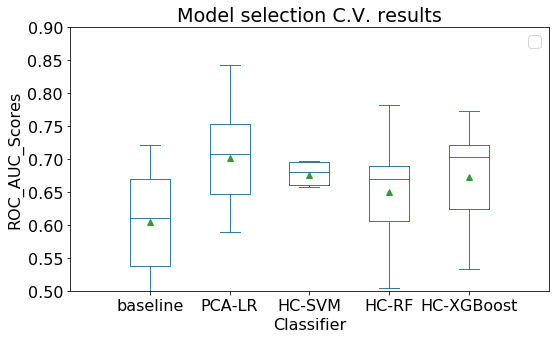

In [58]:
results_dirs = [r'.\tut-2-model_selection_cv\baseline\baseline\prot_vecs_sum_trigrams\random\SVM'
                    ,r'.\tut-2-model_selection_cv\standardise\PCA\PCs\random\LR'
                    ,r'.\tut-2-model_selection_cv\data_Hierarchical_clustering\clusters=140\bpas_hc_normalised_vecs\random\SVM'
                    ,r'.\tut-2-model_selection_cv\data_Hierarchical_clustering\clusters=100\bpas_hc_normalised_vecs\random\RF'
                    ,r'.\tut-2-model_selection_cv\data_Hierarchical_clustering\clusters=80\bpas_hc_vecs\random\XGBoost']
    
d_path = make_dir(['tut-2-model_selection_cv'])

all_results

grouped_box_plot_model_results(results_dirs,plot_filename=d_path + r'//finalised_models_cv_results_comparison.png')

{'baseline': {'fold_id': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  'test_auc': [0.61625,
   0.585,
   0.475,
   0.60625,
   0.72125,
   0.6737499999999998,
   0.6575,
   0.495,
   0.5225,
   0.6875],
  'best_inner_hparams': [{'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'},
   {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'},
   {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'},
   {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'},
   {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'},
   {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'},
   {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'},
   {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'},
   {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'},
   {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}]},
 'PCA-LR': {'fold_id': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  'test_auc': [0.615,
   0.645,
   0.755,
   0.6525,
   0.7475,
   0.8425,
   0.7575,
   0.5900000000000001,
   0.71,
   0.705],
  'best_inner_hparams': [{'C': 0.01},
   {'C': 0.01},
   {'C

The model selection box-plot in the paper can also be found as "finalised_models_cv_results_comparison.png" 
in the ".\tut-2-model_selection_cv_prev_to_last" folder in the directory where this jupyter notebook is placed

Please note that there might be slight differences in the box plot (especially in the std.dev observed in each model) when this tutorial is run on Intel CPUs. We are actively looking on how to handle this and have been in contact with engineers to mitigate this issue.
More specifically:

The scores reported in my AMD CPU were:
Baseline: 0.60 (0.08 std.dev)
Optimal (PCA-LR): 0.70 (0.07 std.dev)
HC-SVM: 0.68 (0.07 std.dev)
HC-XGBoost: 0.67 (0.08 std.dev)
HC-RF: 0.65 (0.08 std.dev)

The scores reported in an Intel CPU were:
Baseline: 0.62 (0.11 std.dev)
Optimal (PCA-LR): 0.71 (0.08 std.dev)
HC-SVM: 0.69 (0.08 std.dev)
HC-XGBoost: 0.66 (0.06 std.dev)
HC-RF: 0.68 (0.09 std.dev)

0.07420242583635657